# Comprehensive Data Visualization - Interactive M5 EDA

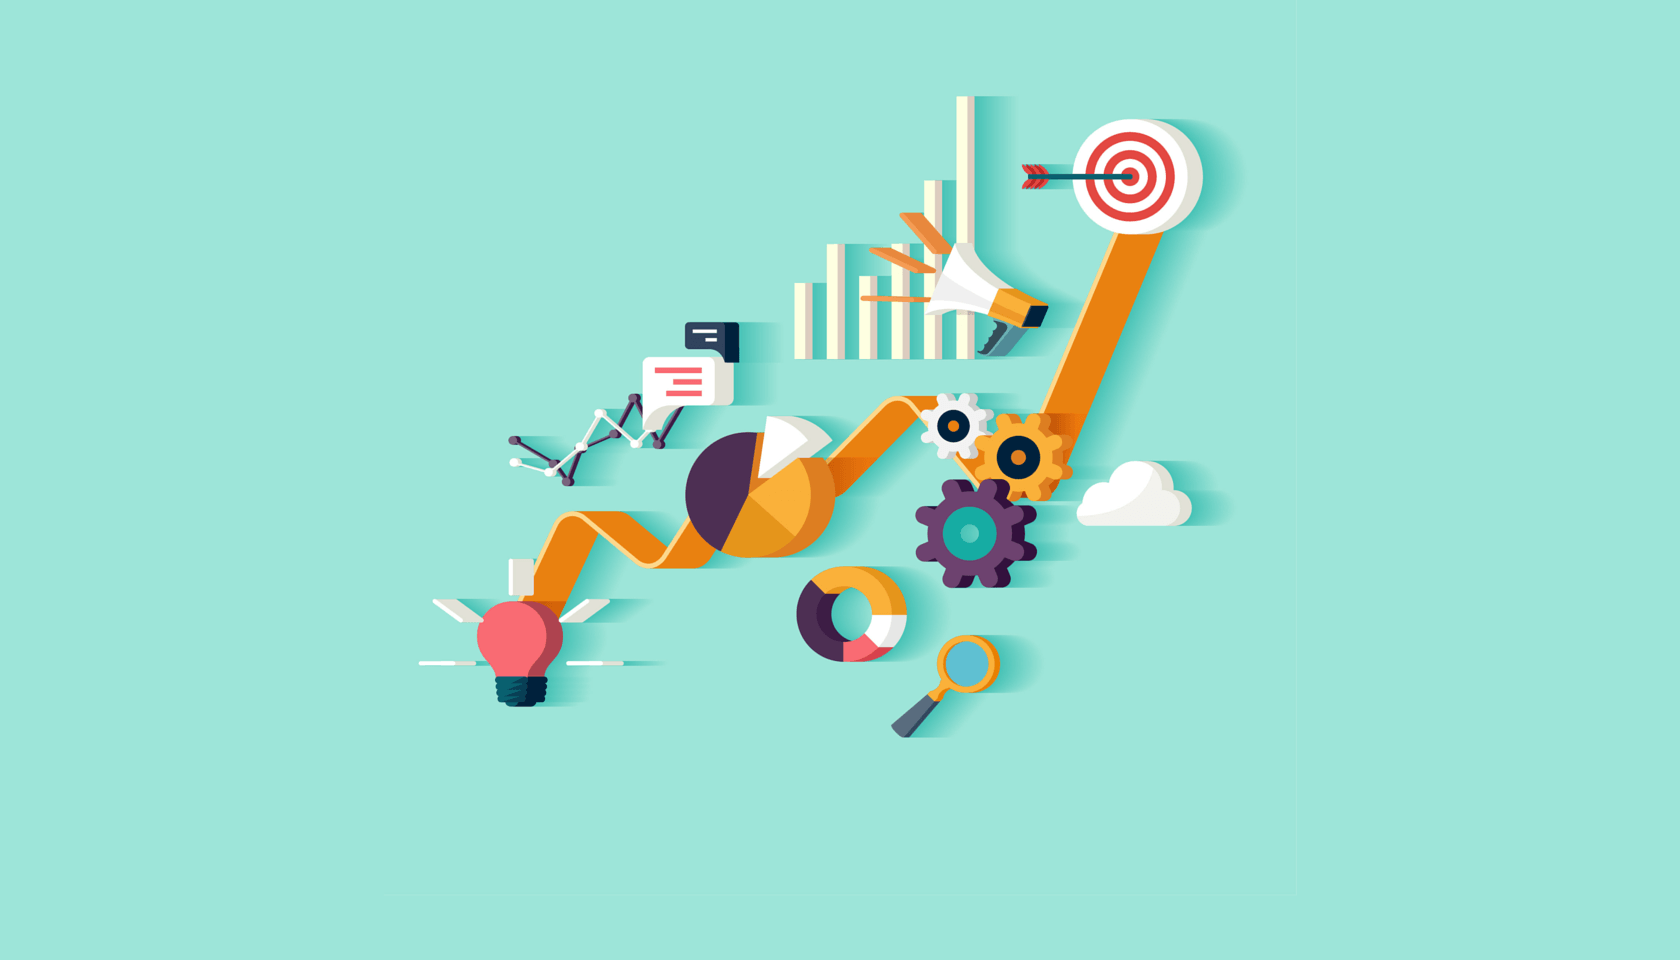

# **Introduction**

Welcome to the comprehensive Exploratory Data Analysis for the 5th Makridakis forecasting competitions (M5). This notebook will grow over the coming days to include model section and model building to forecast the Walmart sales. Before we kickstart, let's take a brief background on the competetion: 

***Objective***: We have to predict Walmart sales for future 28 days based on heirarchical sales in the states of California, Texas, and Wisconsin. “Hierarchical” means that data can be aggregated on different levels: item level, department level, product category level, and state level. In addition, we are also given corresponding data on prices, promotions, and holidays which can be merged with sales data to draw insights. 

In this ***kernel***, I will provide comprehensive Exploratory Data Analysis on the entire dataset. I shall be using Plotly(mostly) and Matplotlib, so be ready to hover your mouse! :)

*In the second stage(which is still in progress), I will work on model section and model building on this problem and will attempt to forecast sales.*

<font size=3 color="red">Please upvote this kernel if you like it. It will motivate me to contribute to the Data Science Community :)</font>

# Table of Contents

[1. Meeting the Data](#section-one)
    
[2. EDA - Interactive Time Series Plots](#section-two)
   - [2.1 Explanatory Variables: Sales Train Validation](#subsection-one)
   - [2.2 Explanatory Variables: Calendar](#subsection-two) 
   - [2.3 Explanatory Variables: Sell Price](#subsection-three)
    
[3. Models : Selection and Building](#section-three) (Work in Progress)

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Importing neccesary packages

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 2000)

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

from datetime import datetime

<a id="section-one"></a>
# Meeting the Data

In [ ]:
# Loading the data

calendar= pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/calendar.csv")
stv = pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/sales_train_validation.csv")
sp = pd.read_csv("/kaggle/input/m5-forecasting-uncertainty/sell_prices.csv")

In [ ]:
# Checking sales training data

stv.head()

In [ ]:
# Checking the shape

stv.shape, calendar.shape, sp.shape

In [ ]:
# Checking unique values across categorical variables

cols = ["dept_id", "cat_id", "store_id", "state_id"]

print([stv[i].nunique() for i in cols])
print([stv[i].unique() for i in cols])

***Key Observations***

* This is our training data. It has 1 column (d_* ) for each of the 1913 days starting from 2011-01-29 whcih represents the number of units sold per day, plus a general ID that is a combination of the other IDs plus a flag for validation.
* It also includes the IDs for item, department, category, store, and state. 
* The number of rows are 30490 acorss 3 States ('CA', 'TX', 'WI'), 3 categories ('HOBBIES', 'HOUSEHOLD', 'FOODS'), 3 departments and 10 stores ('CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1','WI_2', 'WI_3')

In [ ]:
# Checking calendar data

calendar.head()

***Key Observations***

* This is our calendar data. It has 1969 rows and 14 columns.
* It includes features like day-of-the week, month, year, and an 3 binary flags for whether the stores in each state allowed purchases with SNAP food stamps at this date (1) or not (0)

In [ ]:
# Checking the sell price data

sp.head()

***Key Observations***

* Here, the sales price of the item is presented as a weekly average across the store and item IDs together. 
* We will combine Calendar and Sell price data with training data to generate insights in the later steps.

<a id="section-two"></a>
# EDA - Interactive Time Series Plots

In [ ]:
# Checking missing values first

stv.isnull().sum().sort_values(ascending=True)

No missing values, good news !

In [ ]:
# Collecting all days columns (d_*) in a list for data wrangling

d_cols = [col for col in stv.columns if "d_" in col]

In [ ]:
# Short helper function for data transformation

def helper_func(df):
    df = df.drop(["item_id","dept_id","cat_id","store_id","state_id"], axis=1)
    df = df.melt(id_vars="id",var_name='dates',value_name="sales" )
    df["id"] = df["id"].str.replace('_validation', '')
    return df

<a id="subsection-one"></a>
# 2.1 Explanatory Variables: Sales Train Validation

### Random sample
Let's take a random sample and see the distribution - 

In [ ]:
# Taking 50 random samples to see the sales distribution
stv_= stv.sample(n=50, random_state=1)

stv_random = helper_func(stv_)

merged = stv_random.merge(calendar, how="left", left_on="dates", right_on="d")

merged_ = pd.DataFrame(merged.groupby("date")["sales"].sum()).reset_index()

fig = px.line(merged_, x="date", y="sales", title='Sales Distribution of random 50 Samples', color_discrete_map= dict(color="red"))
fig.show()

### Aggregate Sales

After peeking at a random 50 samples, we will now do some aggregation to get some decent statistics.

Firstly, we plot the aggregate time series over all items, stores, categories, departments and sales. This is an interactive plot and you can use the usual plotly tools (upper right corner) to zoom, pan, and scale the view.

In [ ]:
# Aggregate sales distribution

stv_agg = pd.DataFrame(stv[d_cols].sum()).rename(columns = {0:"sales"})

agg = stv_agg.merge(calendar.set_index("d"), how="left", left_index=True,
             right_index=True, validate="1:1")


fig = px.line(agg, x="date", y="sales")
fig.show()

***Key Observations***:

* The sales has an upward trend. We can observe some yearly seasonality, and a dip at Christmas (zoom-in to see), which is the only day of the year when the stores are closed.

* Further zooming in, we can see strong weekly seasonality (sales going up on weekends, lower in the middle of the week).

### Aggregate Sales across the States

In [ ]:
# sales distribution across states

state_agg = stv.groupby("state_id")[d_cols].sum()\
                        .T\
                        .merge(calendar.set_index("d"), how="left", left_index=True,
                         right_index=True, validate="1:1")\
                        .loc[:, ["CA","WI","TX","date"]]

state_agg["date"] = pd.to_datetime(state_agg["date"])

state_agg = state_agg.set_index("date")\
                        .resample("1m").sum()


# Line Plot with plotly.express

fig = px.line(state_agg, title='Sales across States')
fig.show()

***Key Observations***:

* California (CA) sells more items continuously, while Wisconsin (WI) sales were lower till 2013 and then slowly catching up to Texas (TX) and eventually surpassed it in the last months of our training data.

* All 3 states experienced dip in start of each year, and then moving up during the middle of each year and then again going down towards the end of the year. This pattern is consistent across all 3 states.

### Aggregate Sales across the Stores

In [ ]:
# sales distribution across stores

store_agg = stv.groupby("store_id")[d_cols].sum()\
                        .T\
                        .merge(calendar.set_index("d"), how="left", left_index=True,
                         right_index=True, validate="1:1")\
                        .loc[:, "CA_1":"date"]

store_agg["date"] = pd.to_datetime(store_agg["date"])

store_agg = store_agg.set_index("date")\
                        .resample("1m").sum()


# Line Plot with plotly.express

fig = px.line(store_agg, title='Sales across Stores')
fig.show()

***Key Observations***:

* Cleary California's stores outperforms other two states stores at mean aggregate sales. CA_3 is the clear winner among all stores, it consistly sells more items. While, CA_4 ranks the lowest.

* CA_2 experienced a high jump in June-2015 till Sep-2015 and then catching up with rest of the stores goig forward. Maybe there were store developments or change in policy (just a thought!) 

### Sales Distributon by Stores across the States

In [ ]:
# sales distribution by stores across states

store_agg1 = stv.groupby("store_id")[d_cols].sum()\
                        .T\
                        .merge(calendar.set_index("d"), how="left", left_index=True,
                         right_index=True, validate="1:1")\
                        .loc[:, "CA_1":"WI_3"].reset_index()\
                        .melt(id_vars = "index", var_name= "store_id", value_name="sales")

# Box Plot with plotly.express

fig = px.box(store_agg1, x="store_id", y="sales", color="store_id", points="all", title="Sales Distribution by Stores across States")

fig.show()

***Key Observations***:

* The above plot compares the sales distribution for each stores across states. The stores in California seem to have the highest variance in sales, which might indicate that some places in California grow significantly faster than others, i.e. there is income disparity. 

* On the other hand, the Wisconsin and Texas sales seem to be quite consistent among themselves, without much variance. This indicates that development might be more uniform in these states.

* The variance is lowest in Wisconsin and highest in California.

* Zero sales corrosponds to Christmas when stores are closed. Also, there are a few days where the daily sales is higher than the average sales among few stores (TX_2/3, WI_1/2).

### Average Sales across Stores

In [ ]:
### Average Sales across Stores

store_agg1_ = pd.DataFrame(store_agg1.groupby("store_id")["sales"].mean()).reset_index()

# Bar Plot with plotly.express

fig = px.bar(store_agg1_, y="sales", x="store_id", color="store_id", title="Mean sales across Stores", text="sales")
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')

***Key Observations***

* California stores have the highest variance and mean sales among all the stores. The store CA_3 has maximum sales while the store CA_4 has minimum sales, clearly indicate income disparity.
 
* Texas stores ranks second in the overall mean sales and showing similar mean Sales across its 3 stores, TX_2 being the highest and TX_1 being the lowest. Clearly, no disparity.
 
* Wisconsin's stores are no far off than Texas's, WI_2 and W1_3 have same mean Sales, W1_1 lowest among them.

### Sales Distribution across Category and Departments

In [ ]:
### Sales Distribution across Category and Departments

cat_agg = stv.groupby(["cat_id", "dept_id"])[d_cols].sum()
cat_agg = pd.DataFrame(cat_agg.sum(axis=1)).reset_index().rename({0:"sales"}, axis=1)

# Subplots and Pie charts with plotly

fig = make_subplots(rows=1, cols=2,specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(values=cat_agg['sales'], labels=cat_agg['cat_id']), 1,1)
fig.add_trace(go.Pie(values=cat_agg['sales'], labels=cat_agg['dept_id']), 1,2)

# updating traces and layout

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Percentage Sales Distribution across Category and Departments",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Category', x=0.18, y=0.5, font_size=20, showarrow=False),
                 dict(text='Department', x=0.82, y=0.5, font_size=20, showarrow=False)])

fig.show()

### Total Sales across Departments

In [ ]:
# Bar Plot with plotly.express

fig = px.bar(cat_agg, y='sales', x='dept_id', text='sales', title="Total Sales across Departments", color="dept_id")

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

***Key Observations:***

* “Foods” are the most common category (~69%), followed by “Household” (22%) and then “Hobbies” (9.32%). Total Sales of Foods_3 (32M) is close to rest of the department's sales combined.
* "Food_3" contributes 50% of Foods overall sales. It is also the highest sales contributer amongst all departments.
* "Household_1" and "Hobbies_1" are the highest sales contributer within Household and Hobbies category respectively.

### Total Sales in States across Departments

In [ ]:
### Total Sales in States across Departments

state_dept = stv.groupby(["state_id","dept_id"])[d_cols].sum()
state_dept = state_dept.sum(axis=1)
state_dept = pd.DataFrame(state_dept).reset_index().rename({0:"sales"}, axis=1)

# Bar Plot with plotly.express

fig = px.bar(state_dept, x="state_id", y="sales", color="dept_id", text="sales", title="Sales per Department across States")

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

***Key Observations:***

* “FOODS_3” is clearly driving the majority of “FOODS” category sales. 
* Similarly, “HOUSEHOLD_1” is clearly outselling “HOUSEHOLD_2”. “HOBBIES_1” is on a higher total sales level than “HOBBIES_2”.

 <a id="subsection-two"></a>
 # 2.2 Explanatory Variables: Calendar
 
 ## 2.2.1 Calendar : Year/Month/Weekdays Insights
 
Let's so some data wrangling to produce sales distribution insights across year, month and weekdays:

### Year-wise Insights

In [ ]:
# yearly sales distribution

stv1 = pd.DataFrame(stv[d_cols].T.sum(axis=1))\
                                        .rename({0:"sales"}, axis=1)\
                                        .merge(calendar.set_index("d"),how="left", left_index=True,
                                         right_index=True, validate="1:1")

stv1 = stv1.groupby(["year","month","weekday"])["sales"].sum()
stv1 = pd.DataFrame(stv1)

# Bar Plot with plotly.express

fig = px.bar(stv1.reset_index(), x="year", y="sales", color="year", text="sales", title="Year-wise Contribution across each Month")

fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

### Month-wise Insights

In [ ]:
# monthly sales distribution

stv1 = pd.DataFrame(stv[d_cols].T.sum(axis=1))\
                                        .rename({0:"sales"}, axis=1)\
                                        .merge(calendar.set_index("d"),how="left", left_index=True,
                                         right_index=True, validate="1:1")

stv1 = stv1.groupby(["year","month","weekday"])["sales"].sum()
stv1 = pd.DataFrame(stv1)

# Bar Plot with plotly.express

fig = px.bar(stv1.reset_index(), x="month", y="sales", color="weekday", text="sales", title="Monthy Sales bifurcated by weekdays")

fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

### Weekdays Insights

In [ ]:
# weekday sales distribution

_stv1 = stv1.reset_index()

# Pie charts with plotly

colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen', "red", "cyan", "blue"] #setting colors for each weekday

fig = go.Figure(data=[go.Pie(labels=_stv1["weekday"],
                             values=_stv1["sales"], pull=[0, 0.2, 0.1, 0, 0, 0, 0])])

fig.update_traces(hoverinfo='label+percent+name', textinfo='value', textfont_size=15,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Weekdays Contribution",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Weekday', x=0.5, y=0.5, font_size=20, showarrow=False)])

fig.show()

***Key Observations:***

* Sales has an increasing trend over the years, which is good for Walmart.
* Sales is the highest in March and lowest in January and May. The months of Nov and Dec show clear dips, while the summer months May, Jun, and Jul suggest a milder secondary dip.
* Weekends (Sunday and Saturday) are the highest sales contributer, followed by Friday and Monday, seems like they get benefit from the weekend!
* Wednesday has lowest sales which is understood, middle of the week!

### Let's bring everything together!

In [ ]:
# Bar Plot with plotly.express

fig = px.bar(stv1.reset_index(), x="month", y="sales", color="weekday", 
            facet_row="year", facet_col="weekday", text="sales", title="Sales across each Month on Weekdays across Years")

fig.update_traces(texttemplate='%{text:.2s}', textposition='auto')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

## 2.2.2 Calendar : Events Insights

* There are other features which deals with events and food stamps.
* There are two types of events in the dataset, Event_1 and Event_2. We will analyze each one of them.
* Also, there are 3 SNAP columns, the acronym SNAP stands for [Supplemental Nutrition Assistance Program](http://www.benefits.gov/benefit/361). 

***What is this program?***

*The Supplemental Nutrition Assistance Program (SNAP) is the largest federal nutrition assistance program. SNAP provides benefits to eligible low-income individuals and families via an Electronic Benefits Transfer card. This card can be used like a debit card to purchase eligible food in authorized retail food stores.*


###  Event_1 Analysis

In [ ]:
# Bar charts with matplotlib

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,5))
fig.suptitle("Days with Event_1 Summary", fontsize=20)

calendar["event_name_1"].isnull().value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Days without Events (%)", ax=ax1, title="Days without Events (%)")

calendar["event_type_1"].value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Days with Events (%)", ax=ax2, color='y', title="Events Type (%)")

In [ ]:
# considering only event days for analysis 

calendar_e1 = calendar[~calendar["event_name_1"].isnull()]

event1 = pd.DataFrame(calendar_e1[["event_type_1", "event_name_1"]].value_counts())\
                                                                   .reset_index()\
                                                                   .rename({0:"events"}, axis=1)

# subplots and pie charts with plotly

fig = make_subplots(rows=1, cols=2,specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(values=event1['events'], labels=event1['event_type_1']), 1,1)

fig1 = px.sunburst(event1, path=['event_type_1', 'event_name_1'], values='events',
                  color='events',hover_data=['events'], color_continuous_scale='RdBu', title = "Events distribution per Event Types")

fig.update_traces(hole=.4, hoverinfo="label+percent+name")
fig.update_layout(
    title_text="Events Distribution by Event Type",
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Event Type', x=0.18, y=0.5, font_size=20, showarrow=False)])

fig.show()
print(event1)
fig1.show()

***Key Observations:***

* In our calendar data, about 8% of days have a special event. Of these events, about 1/3 are Religious and National Holidays. The remaining third is again split into 2/3 Cultural and 1/3 Sporting events.

* Second pie charts depicts the event's count by event type. Father's day occured only 4 times, while many of them have a count of 5 & 6.

###  Event_2 Analysis

In [ ]:
# Bar charts with matplotlib

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24,6))
fig.suptitle("Event_2 Summary", fontsize=20)

calendar["event_name_2"].isnull().value_counts()\
                                                .plot(kind="barh", xlabel="Days without Events (%)", ax=ax1, title="Count of Days without Events")

calendar["event_type_2"].value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Days with Events (%)", ax=ax2, color='y', title="Events Type (%)")

calendar["event_name_2"].value_counts(normalize=True)\
                                                .plot(kind="barh", xlabel="Event Name", ax=ax3, color='g', title="Events Names (%)")

***Key Observations:***

* In our calendar data, about 0.002% of days (5 days in total) have a special event. Of these events, about 80% are Cultural and rest 20% are Religious. Father's day has the highest percentage (40%), rest of the events have equal percentages (20%).

## 2.2.3 SNAP Days Analysis

In [ ]:
#snap days purchases

snap = ['snap_CA',"snap_TX","snap_WI"]

pd.DataFrame([calendar[s].value_counts(normalize=True) for s in snap])\
                                    .plot(kind="barh", figsize=(10,5), title="% of Days with SNAP purchases")

***Key Observations:***

Looking at the percentage of days where purchases with SNAP food stamps are allowed in Walmart stores, we find that it is the exact same for each of the 3 states: 650 days or 33%. This is noteworthy.

 <a id="subsection-three"></a>
 # 2.3 Explanatory Variables: Sell Price
 
Let's do some data manipulation to extract some of the features from existing features:

In [ ]:
# Extracting categorty, department and state IDs from dataset

sp["cat_id"] = sp["item_id"].apply(lambda x : str.rstrip(x[:-6]))
sp["dept_id"] = sp["item_id"].apply(lambda x : x[-5])
sp["state_id"] = sp["store_id"].apply(lambda x : x[:-2])

### Density Plot

In [ ]:
# Plotting sell price density plots

plt.figure(figsize=(25,6))

p1 = sns.kdeplot(sp[sp['cat_id']=='HOBBIES']['sell_price'], shade=True, color="b")

p2 = sns.kdeplot(sp[sp['cat_id']=='FOODS']['sell_price'], shade=True, color="r")

p3 = sns.kdeplot(sp[sp['cat_id']=='HOUSEHOLD']['sell_price'], shade=True, color="g")

plt.legend(labels=['HOBBIES','FOODS',"HOUSEHOLD"])
plt.xscale("log")
plt.xlabel("Log of Prices")
plt.ylabel("Density")
plt.title("Density plot of log of prices accross Categories")

***Key Observations:***

* Most of the prices for food products lie between 1 dollars and 10 dollars. As we can see the high peak between 10^0 and 10^1. 
* Hobbies show a pretty wide range of prices.
* Households are costlier than Food.

### Selling Price Distribution across Categories, States and Departments

In [ ]:
# Plotting Selling Price Distribution across Categories, States and Departments

df = sp.groupby(["cat_id", "state_id","dept_id"])["sell_price"].agg(["mean","sum"])
df.reset_index(inplace=True)

# plots with plotly

fig = px.sunburst(df, path=['cat_id', 'state_id',"dept_id"], values='sum',
                  color='mean',hover_data=['mean'], color_continuous_scale='RdBu', title = "Selling Price Distribution across Categories, States and Departments")

fig1 = px.treemap(df, path=['cat_id', 'state_id',"dept_id"], values='sum',
                  color='sum',hover_data=['sum'])

print(df)
fig.show()
fig1.show()

***Key Observations:***

* HOUSEHOLD has the highest average sales, followed by HOBBIES and FOODS.
* Department 1 in HOBBIES has the highest average Sales, while department 3 in FOODS has the lowest average sales.
* Department 2 in HOUSEHOLD has the highest Sales across all 3 states.
* Department 2 in HOBBIES has the lowest Sales across all 3 states.
* Department 3 in FOODS has the lowest Sales across all 3 states.

### Event vs Non Event Analysis

In [ ]:
# Median Sales during event vs non-event days

df2 = stv.groupby("cat_id")[d_cols].sum()\
                             .T\
                             .merge(calendar[["date","d","event_type_1"]].set_index("d"), how="left", left_index=True,
                              right_index=True, validate="1:1")

df2["event_type_1"] = df2.event_type_1.map({'Sporting':"Event", 'Cultural':"Event", 'National':"Event", 'Religious':"Event"})
df2.event_type_1.fillna("No Event", inplace=True)

df2_ = df2.melt(id_vars=["date","event_type_1"], var_name='category',value_name="sales")
df2_ = df2_.groupby(["category","event_type_1"])["sales"].median().reset_index()

fig = px.bar(df2_, x="category", y="sales", color="event_type_1", title="Median Sales on Event vs Non-Event Days", text="sales")
fig.show()

In [ ]:
# Event vs Non event Sales distribution

fig1 = px.line(df2, x="date", y="FOODS", color="event_type_1", title = "Event vs Non-Event Sales distribution across Categories")

fig2 = px.line(df2, x="date", y="HOBBIES", color="event_type_1")

fig3 = px.line(df2, x="date", y="HOUSEHOLD", color="event_type_1")

fig1.show()
fig2.show()
fig3.show()

***Key Observations***

For FOODS the lines of event vs non-event sales are pretty similar, while for HOBBIES the red event line is consistently below the non-events and for HOUSEHOLD the same is true after 2013.

The FOODS sales are pretty comparable between events and non-events, while the event sales for HOUSEHOLD and especially HOBBIES are notably below the non-event level.

### Category-wise Sales Contribution on Event Days

In [ ]:
# Category-wise Sales Contribution on Event Days

df3 = stv.groupby("cat_id")[d_cols].sum()\
                             .T\
                             .merge(calendar[["date","d","event_type_1"]].set_index("d"), how="left", left_index=True,
                              right_index=True, validate="1:1")

df3_ = df3[~df3["event_type_1"].isnull()]\
                            .groupby("event_type_1")[["FOODS", "HOBBIES", "HOUSEHOLD"]].sum()\
                            .reset_index()

# Define color sets of paintings
food_colors = ['rgb(56, 75, 126)', 'rgb(18, 36, 37)', 'rgb(34, 53, 101)',
                 'rgb(36, 55, 57)']
hobb_colors = ['rgb(33, 75, 99)', 'rgb(79, 129, 102)', 'rgb(151, 179, 100)',
                 'rgb(175, 49, 35)']
house_colors =  ['rgb(146, 123, 21)', 'rgb(177, 180, 34)', 'rgb(206, 206, 40)',
                'rgb(175, 51, 21)']


fig = make_subplots(1, 3, specs=[[{'type':'domain'}, {'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['FOODS', 'HOBBIES', "HOUSEHOLD"])

fig.add_trace(go.Pie(labels=df3_["event_type_1"], values=df3_["FOODS"], textinfo='label+percent', marker_colors=food_colors), 1, 1)
fig.add_trace(go.Pie(labels=df3_["event_type_1"], values=df3_["HOBBIES"], textinfo='label+percent', marker_colors=hobb_colors), 1, 2)
fig.add_trace(go.Pie(labels=df3_["event_type_1"], values=df3_["HOUSEHOLD"], textinfo='label+percent', marker_colors=house_colors), 1, 3)


fig.update_layout(title_text='Category-wise Sales Contribution on Event Days')
fig.show()

***Key Observations***

* Natioal and Religious events contributes for the maximum sales across all 3 categories.
* Sporting events has lower contribution towards the net sales.

This concludes Exploratory Data Analysis on this amazing dataset. Many thanks to all of you for reading this kernel, please do provide your feedback in the shapes of upvotes and comments. 

I’ll be glad if you find my work useful, and I’m always open to questions and constructive criticism. I thoroughly appreciate your support! 

<a id="section-three"></a>
# 3. Models : Selection and Building

This section will get updated in next few days. 

Happy Learning !